In [4]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn import metrics
import lightgbm as lgb
from copy import deepcopy
# import graphviz
import os
from sklearn import preprocessing
%matplotlib inline
plt.rcParams['figure.figsize']=12,4

In [5]:
current_dir = r'D:\yuwei\study\competition\Predict-demand-online-classified-ad'
data_dirs = dict()
data_dirs['train_data'] = os.path.join(current_dir, 'data/train.csv')
data_dirs['test_data'] = os.path.join(current_dir, 'data/test.csv')
data_dirs['pred_result'] = os.path.join(current_dir, 'data/20180502_03LightGBM_addFeatures.csv')
data_dirs['model_path'] = os.path.join(current_dir, 'data/model_data/20180502_03LightGBM_addFeatures.pkl')

### 新增几个特征（monthday,*_w_count,*_len,image_exists）

In [6]:
def word_count(raw_text):
    if type(raw_text) == float:
        return 0
    return len(raw_text.split()) 
    
def count_chars(raw_text):
    if type(raw_text) == float:
        return 0
    return len(raw_text)

def prepare_data(data_dirs):
    train_df = pd.read_csv(data_dirs['train_data'], parse_dates=["activation_date"])
    test_df = pd.read_csv(data_dirs['test_data'], parse_dates=["activation_date"])
    
    use_features = set()

    train_y = train_df["deal_probability"].values
    test_id = test_df["item_id"].values
    # explore features
    # [1]weekday
    train_df["activation_weekday"] = train_df["activation_date"].dt.weekday
    test_df["activation_weekday"] = test_df["activation_date"].dt.weekday
    # [2]monthday
    train_df["activation_monthday"] = train_df["activation_date"].dt.day
    test_df["activation_monthday"] = test_df["activation_date"].dt.day
    # [3]hour
    train_df['activation_hour'] = train_df["activation_date"].dt.hour
    test_df['activation_hour'] = test_df["activation_date"].dt.hour
    
    use_features.update(['activation_weekday','activation_monthday','activation_hour'])
    
    text_columns=['param_1','param_2','param_3','title','description']+['parent_category_name','category_name']
    for feat_name in text_columns:
        # [4]char length
        feat_len = feat_name+"_len"
        train_df[feat_len] = train_df[feat_name].apply(count_chars)
        test_df[feat_len] = test_df[feat_name].apply(count_chars)
        # [5]word count
        feat_w_count = feat_name+"_w_count"
        train_df[feat_w_count] = train_df[feat_name].apply(word_count)
        test_df[feat_w_count] = test_df[feat_name].apply(word_count)
        
        use_features.update([feat_len, feat_w_count])
    
    # [6]images length
    train_df['image_exists'] = train_df['image'].isnull().astype(int)
    test_df['image_exists'] = test_df['image'].isnull().astype(int)
    
    use_features.add('image_exists')
    
    
    # [7]Label encode the categorical variables #
    cat_vars = ["region", "city", "parent_category_name", "category_name", "user_type", "param_1", "param_2", "param_3"]
    for col in cat_vars:
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
        train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
        test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))
    
    use_features.update(cat_vars)
    
    use_features.update(['price', 'item_seq_number', 'image_top_1'])
    use_features=list(use_features)
    train_X = train_df[use_features]
    test_X = test_df[use_features]
    return train_X, train_y, test_X, test_id, cat_vars+['activation_weekday','activation_monthday','activation_hour']

In [7]:
train_X, train_y, test_X, test_id, cat_vars= prepare_data(data_dirs)

In [11]:
X_train,X_val,y_train,y_val=train_test_split(train_X,train_y,test_size=0.20,random_state=9)

# 1 Base line

In [12]:
def modelfit(alg,X,y,X_test,y_test,cat_features,cvparams,folds=None,useTrainCV=True,cv_folds=5,early_stopping_rounds=30):
    feature_names=list(X.columns)
    if useTrainCV==True:
        dtrain=lgb.Dataset(X, label=y, reference=None, 
                           weight=None, group=None, silent=False, feature_name=feature_names,
                            categorical_feature=cat_features,params=None, free_raw_data=True)
        cvresult=lgb.cv(cvparams,dtrain,num_boost_round=5000,folds=folds,nfold=cv_folds,stratified=False,
                        metrics='rmse',feature_name=feature_names,categorical_feature=cat_features,early_stopping_rounds=early_stopping_rounds,
                        verbose_eval=20,show_stdv =True,seed=9)
        #,feval=gini_normalized
        alg.set_params(n_estimators=len(cvresult['rmse-mean']))
        print('Best Iteration:',len(cvresult['rmse-mean']))
        
    alg.fit(X,y,eval_metric='rmse',feature_name=feature_names,categorical_feature=cat_features,
            eval_set=[(X,y),(X_test, y_test)],eval_names=['train','val'],verbose=20)
    
    #Predict training set:
    dtrain_predictions=alg.predict(X)
    
    #pPredict test set:
    dtest_predictions=alg.predict(X_test)
    
    #Print Mode report:
    print('Model report on trian:')
    print('Train RMSE:{0:.4f}'.format(np.sqrt(metrics.mean_squared_error(y,dtrain_predictions))))
    print('Model report on test:')
    print('Test RMSE:{0:.4f}'.format(np.sqrt(metrics.mean_squared_error(y_test,dtest_predictions))))
    
    feat_imp=pd.Series(alg.feature_importances_,index=X.columns).sort_values(ascending=True)
    #plt.figure()
    #feat_imp.plot(kind='barh',title='Feature Importances',color='green')
    #plt.ylabel('Feature Importance Score')
    lgb.plot_importance(alg,importance_type='gain')
    lgb.plot_metric(lgbr)
    return feat_imp

def turnParams(model,X,y,cat_features,searchParam,modelparams,scoring='rmse',cv=5):
    gsc=GridSearchCV(estimator=model.__class__(**modelparams),param_grid=searchParam,scoring=scoring,
                    iid=False,cv=cv)
    gsc.fit(X,y,eval_metric='rmse',categorical_feature=cat_features)
    param_name=list(searchParam.keys())[0]
    columns=[p[param_name] for p in gsc.cv_results_['params']]
    cv_scores=pd.DataFrame([gsc.cv_results_['mean_test_score'],
                            gsc.cv_results_['mean_train_score'],
                            gsc.cv_results_['std_test_score'],
                            gsc.cv_results_['std_train_score']],
                            index=['mean_test_score','mean_train_score','std_test_score','std_train_score'],
                            columns=columns).T
    #cv_scores.index.name=param_name
    for param in gsc.best_params_.keys():
        modelparams[param]=gsc.best_params_[param]
    print('Best params:')
    for param in gsc.best_params_.keys():
        print(param,':',gsc.best_params_[param])
    print('Best score:',gsc.best_score_)
    print(cv_scores)

In [18]:
params={'boosting_type': 'gbdt',
        'colsample_bytree': 0.8,
       'learning_rate': 0.2,
       'max_bin': 168,
       'max_depth': 9,
       'min_child_samples': 30,
       'min_child_weight': 5,
       'min_split_gain': 1,
       'n_estimators': 200,
       'n_jobs': -1,
       'num_leaves': 60,
       'objective': 'regression',
       'random_state': 9,
       'reg_alpha': 0,
       'reg_lambda': 0,
       'subsample': 0.9,
       'subsample_freq': 1
       }

cvparams={'boosting_type':'gbdt',
        'num_leaves':60,
        'max_depth':9,
        'learning_rate':0.2,
        'max_bin':168,
        'objective':'regression',
        'min_gain_to_split':1,
        'min_sum_hessian_in_leaf':5,
        'min_data_in_leaf':1,
        'bagging_fraction':0.9,
        'bagging_freq':1,
        'feature_fraction':0.8,
        'lambda_l1':0,
        'lambda_l2':0,
        'num_threads':-1,
       }
#在sklaearn接口中，参数名称发生了变化，需要进行映射
tran_table={ 'min_split_gain':'min_gain_to_split',
             'min_child_weight':'min_sum_hessian_in_leaf',
             'min_child_samples':'min_data_in_leaf',
             'subsample':'bagging_fraction',
             'subsample_freq':'bagging_freq',
             'colsample_bytree':'feature_fraction',
             'reg_alpha':'lambda_l1',
             'reg_lambda':'lambda_l2',
             'n_jobs':'num_threads',
            
             'boosting_type':'boosting_type',
             'num_leaves':'num_leaves',
             'max_depth':'max_depth',
             'learning_rate':'learning_rate',
             'max_bin':'max_bin',
             'objective':'objective'}
def get_lgb_params(sklearn_params,cvparams,tran_table):
    for sklearn_param,lgb_param in tran_table.items():
        cvparams[lgb_param]=sklearn_params[sklearn_param]

In [19]:
lgbr=lgb.LGBMRegressor(**params)

[20]	cv_agg's rmse: 0.229021 + 0.000194627
[40]	cv_agg's rmse: 0.228182 + 0.000176011
[60]	cv_agg's rmse: 0.228161 + 0.000163267
[80]	cv_agg's rmse: 0.228161 + 0.000163267
Best Iteration: 53


C:\Anaconda3\lib\site-packages\lightgbm\basic.py:1038: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['activation_hour', 'activation_monthday', 'activation_weekday', 'category_name', 'city', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'region', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[20]	train's rmse: 0.22743	val's rmse: 0.229037
[40]	train's rmse: 0.225484	val's rmse: 0.227947
Model report on trian:
Train RMSE:0.2253
Model report on test:
Test RMSE:0.2278


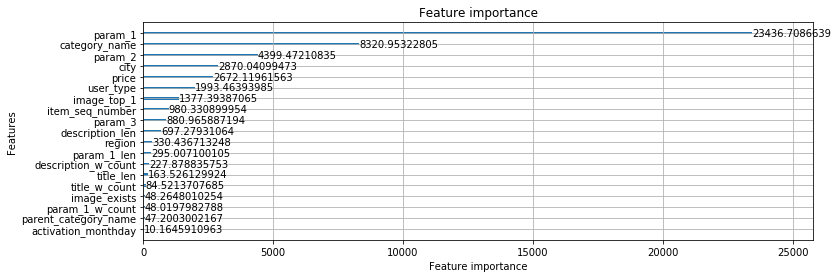

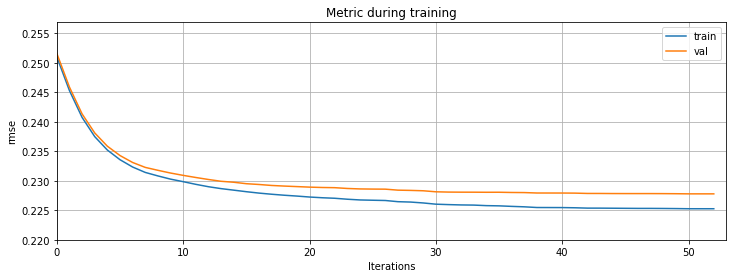

In [20]:
get_lgb_params(lgbr.get_params(),cvparams,tran_table)

feat_imp=modelfit(lgbr,X_train,y_train,X_val,y_val,cat_vars,cvparams,useTrainCV=True,cv_folds=5,early_stopping_rounds=30)

In [21]:
params['n_estimators']=53

# 2 Tune params

In [23]:
#不重要的警告信息不予显示
import warnings
warnings.filterwarnings("ignore")

In [24]:
def rmse(y_true, y_pred, sample_weight=None, multioutput='uniform_average'):
    return np.sqrt(metrics.mean_squared_error(y_true,y_pred))
scorer = metrics.make_scorer(rmse, greater_is_better=False)

## 2.1 num_leaves

In [25]:
searchParam={'num_leaves':(20,50,80,110)}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
num_leaves : 110
Best score: -0.227887702593
     mean_test_score  mean_train_score  std_test_score  std_train_score
20         -0.228822         -0.227187        0.000791         0.000197
50         -0.228293         -0.225900        0.000784         0.000169
80         -0.227998         -0.225104        0.000756         0.000233
110        -0.227888         -0.224706        0.000817         0.000145


In [26]:
searchParam={'num_leaves':(100,110,120,130)}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
num_leaves : 130
Best score: -0.227853583424
     mean_test_score  mean_train_score  std_test_score  std_train_score
100        -0.227906         -0.224846        0.000695         0.000311
110        -0.227888         -0.224706        0.000817         0.000145
120        -0.227867         -0.224634        0.000801         0.000225
130        -0.227854         -0.224590        0.000779         0.000182


In [27]:
searchParam={'num_leaves':(130,140,150,160)}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
num_leaves : 150
Best score: -0.227771596408
     mean_test_score  mean_train_score  std_test_score  std_train_score
130        -0.227854         -0.224590        0.000779         0.000182
140        -0.227819         -0.224525        0.000790         0.000170
150        -0.227772         -0.224348        0.000830         0.000166
160        -0.227786         -0.224342        0.000737         0.000225


In [28]:
searchParam={'num_leaves':(145,149,150,151,155)}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
num_leaves : 149
Best score: -0.22776632486
     mean_test_score  mean_train_score  std_test_score  std_train_score
145        -0.227792         -0.224441        0.000808         0.000237
149        -0.227766         -0.224391        0.000777         0.000161
150        -0.227772         -0.224348        0.000830         0.000166
151        -0.227773         -0.224379        0.000793         0.000178
155        -0.227796         -0.224382        0.000815         0.000074


## 2.2 max_depth

In [29]:
searchParam={'max_depth':[25,30,35,40]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
max_depth : 30
Best score: -0.227401130012
    mean_test_score  mean_train_score  std_test_score  std_train_score
25        -0.227434         -0.222938        0.000809         0.000219
30        -0.227401         -0.222888        0.000824         0.000189
35        -0.227418         -0.222911        0.000824         0.000183
40        -0.227418         -0.222911        0.000824         0.000183


In [30]:
searchParam={'max_depth':[28,29,30,31,32,33]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
max_depth : 30
Best score: -0.227401130012
    mean_test_score  mean_train_score  std_test_score  std_train_score
28        -0.227413         -0.222867        0.000823         0.000161
29        -0.227405         -0.222905        0.000824         0.000183
30        -0.227401         -0.222888        0.000824         0.000189
31        -0.227418         -0.222911        0.000824         0.000183
32        -0.227418         -0.222911        0.000824         0.000183
33        -0.227418         -0.222911        0.000824         0.000183


## 2.3 subsample

In [31]:
searchParam={'subsample':[0.7,0.8,0.9,1.0]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
subsample : 1.0
Best score: -0.227398979869
     mean_test_score  mean_train_score  std_test_score  std_train_score
0.7        -0.227686         -0.223280        0.000796         0.000338
0.8        -0.227469         -0.223031        0.000748         0.000303
0.9        -0.227401         -0.222888        0.000824         0.000189
1.0        -0.227399         -0.222648        0.000837         0.000192


In [32]:
searchParam={'subsample':[0.92,0.94,0.96,0.98,1.0]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
subsample : 1.0
Best score: -0.227398979869
      mean_test_score  mean_train_score  std_test_score  std_train_score
0.92        -0.227456         -0.222873        0.000766         0.000172
0.94        -0.227465         -0.222811        0.000723         0.000209
0.96        -0.227416         -0.222781        0.000824         0.000194
0.98        -0.227442         -0.222712        0.000774         0.000161
1.00        -0.227399         -0.222648        0.000837         0.000192


## 2.4 subsample_freq

In [33]:
#searchParam={'subsample_freq':[1,2,3,4,5,6,7,8,9]}
#turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

## 2.5 colsample_bytree

In [34]:
searchParam={'colsample_bytree':[0.6,0.7,0.8,0.9,1.0]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
colsample_bytree : 0.9
Best score: -0.227385745426
     mean_test_score  mean_train_score  std_test_score  std_train_score
0.6        -0.227502         -0.223204        0.000781         0.000171
0.7        -0.227469         -0.222784        0.000849         0.000170
0.8        -0.227399         -0.222648        0.000837         0.000192
0.9        -0.227386         -0.222466        0.000771         0.000244
1.0        -0.227542         -0.221929        0.000782         0.000267


## 2.6 reg_alpha

In [35]:
#searchParam={'reg_alpha':[0,1e-5,1e-3,0.1,0.5,1,3,5,10]}
#turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

## 2.7 reg_lambda

In [36]:
searchParam={'reg_lambda':[0,1e-5,1e-3,0.1,0.5,1]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
reg_lambda : 1
Best score: -0.227348683245
         mean_test_score  mean_train_score  std_test_score  std_train_score
0.00000        -0.227386         -0.222466        0.000771         0.000244
0.00001        -0.227386         -0.222466        0.000771         0.000244
0.00100        -0.227386         -0.222466        0.000771         0.000244
0.10000        -0.227386         -0.222450        0.000803         0.000192
0.50000        -0.227363         -0.222368        0.000758         0.000165
1.00000        -0.227349         -0.222429        0.000791         0.000257


In [37]:
searchParam={'reg_lambda':[0.9,1,1.1,1.5,2,5]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
reg_lambda : 0.9
Best score: -0.22733279371
     mean_test_score  mean_train_score  std_test_score  std_train_score
0.9        -0.227333         -0.222486        0.000780         0.000218
1.0        -0.227349         -0.222429        0.000791         0.000257
1.1        -0.227364         -0.222391        0.000799         0.000168
1.5        -0.227413         -0.222469        0.000750         0.000259
2.0        -0.227430         -0.222450        0.000777         0.000178
5.0        -0.227340         -0.222472        0.000776         0.000195


## 2.8 min_child_samples

In [38]:
searchParam={'min_child_samples':[20,30,40,50,70,100]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
min_child_samples : 20
Best score: -0.227317850419
     mean_test_score  mean_train_score  std_test_score  std_train_score
20         -0.227318         -0.222398        0.000765         0.000247
30         -0.227333         -0.222486        0.000780         0.000218
40         -0.227325         -0.222421        0.000789         0.000167
50         -0.227347         -0.222441        0.000754         0.000223
70         -0.227369         -0.222485        0.000812         0.000231
100        -0.227409         -0.222432        0.000843         0.000175


In [39]:
searchParam={'min_child_samples':[15,19,20,21,25]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
min_child_samples : 20
Best score: -0.227317850419
    mean_test_score  mean_train_score  std_test_score  std_train_score
15        -0.227357         -0.222440        0.000775         0.000160
19        -0.227325         -0.222406        0.000770         0.000249
20        -0.227318         -0.222398        0.000765         0.000247
21        -0.227324         -0.222428        0.000765         0.000241
25        -0.227335         -0.222482        0.000806         0.000140


## 2.9 min_child_weight

In [40]:
searchParam={'min_child_weight':[1e-5,1e-3,0.1,0.5,1.0,3.0,5.0]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
min_child_weight : 1e-05
Best score: -0.227317850419
         mean_test_score  mean_train_score  std_test_score  std_train_score
0.00001        -0.227318         -0.222398        0.000765         0.000247
0.00100        -0.227318         -0.222398        0.000765         0.000247
0.10000        -0.227318         -0.222398        0.000765         0.000247
0.50000        -0.227318         -0.222398        0.000765         0.000247
1.00000        -0.227318         -0.222398        0.000765         0.000247
3.00000        -0.227318         -0.222398        0.000765         0.000247
5.00000        -0.227318         -0.222398        0.000765         0.000247


## 2.10 max_bin

In [41]:
#searchParam={'max_bin':[31,63,127,255,511]}
#turnParams(lgbc,X,y,cat_features,searchParam,params,scoring='roc_auc',cv=5);

## 2.11 min_split_gain

In [42]:
searchParam={'min_split_gain':[0.5,0.9,1,1.1,2,3]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
min_split_gain : 0.5
Best score: -0.227050005765
     mean_test_score  mean_train_score  std_test_score  std_train_score
0.5        -0.227050         -0.221155        0.000791         0.000203
0.9        -0.227315         -0.222197        0.000835         0.000196
1.0        -0.227318         -0.222398        0.000765         0.000247
1.1        -0.227444         -0.222596        0.000778         0.000196
2.0        -0.227918         -0.224273        0.000766         0.000238
3.0        -0.228390         -0.225554        0.000837         0.000134


In [43]:
searchParam={'min_split_gain':[1e-3,0.01,0.1,0.5]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
min_split_gain : 0.1
Best score: -0.22651358813
       mean_test_score  mean_train_score  std_test_score  std_train_score
0.001        -0.226577         -0.217044        0.000761         0.000200
0.010        -0.226534         -0.216929        0.000745         0.000278
0.100        -0.226514         -0.216939        0.000766         0.000200
0.500        -0.227050         -0.221155        0.000791         0.000203


In [44]:
searchParam={'min_split_gain':[0.09,0.1,0.11,0.12,0.15]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
min_split_gain : 0.15
Best score: -0.226435328478
      mean_test_score  mean_train_score  std_test_score  std_train_score
0.09        -0.226491         -0.216950        0.000756         0.000172
0.10        -0.226514         -0.216939        0.000766         0.000200
0.11        -0.226481         -0.216892        0.000733         0.000144
0.12        -0.226534         -0.216997        0.000760         0.000165
0.15        -0.226435         -0.217079        0.000729         0.000148


In [45]:
searchParam={'min_split_gain':[0.14,0.15,0.2,0.3]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
min_split_gain : 0.2
Best score: -0.226424306857
      mean_test_score  mean_train_score  std_test_score  std_train_score
0.14        -0.226493         -0.217071        0.000762         0.000118
0.15        -0.226435         -0.217079        0.000729         0.000148
0.20        -0.226424         -0.218429        0.000732         0.000254
0.30        -0.226682         -0.219726        0.000746         0.000215


In [46]:
searchParam={'min_split_gain':[0.18,0.2,0.25]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
min_split_gain : 0.18
Best score: -0.226326954271
      mean_test_score  mean_train_score  std_test_score  std_train_score
0.18        -0.226327         -0.217817        0.000769         0.000336
0.20        -0.226424         -0.218429        0.000732         0.000254
0.25        -0.226569         -0.218997        0.000785         0.000287


In [47]:
searchParam={'min_split_gain':[0.16,0.17,0.18,0.19]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
min_split_gain : 0.17
Best score: -0.226278291084
      mean_test_score  mean_train_score  std_test_score  std_train_score
0.16        -0.226357         -0.217431        0.000829         0.000230
0.17        -0.226278         -0.217563        0.000753         0.000139
0.18        -0.226327         -0.217817        0.000769         0.000336
0.19        -0.226343         -0.217959        0.000749         0.000322


## 2.12 lower learning_rate

[20]	cv_agg's rmse: 0.234398 + 0.00017672
[40]	cv_agg's rmse: 0.229387 + 0.000229328
[60]	cv_agg's rmse: 0.227852 + 0.000261265
[80]	cv_agg's rmse: 0.22718 + 0.000278675
[100]	cv_agg's rmse: 0.226765 + 0.00028655
[120]	cv_agg's rmse: 0.226511 + 0.000293873
[140]	cv_agg's rmse: 0.226312 + 0.000280261
[160]	cv_agg's rmse: 0.226165 + 0.000281745
[180]	cv_agg's rmse: 0.22596 + 0.000278506
[200]	cv_agg's rmse: 0.225851 + 0.000278771
[220]	cv_agg's rmse: 0.225843 + 0.000274042
[240]	cv_agg's rmse: 0.225843 + 0.000274042
Best Iteration: 211
[20]	train's rmse: 0.233451	val's rmse: 0.23458
[40]	train's rmse: 0.227458	val's rmse: 0.229494
[60]	train's rmse: 0.224801	val's rmse: 0.2279
[80]	train's rmse: 0.223081	val's rmse: 0.227213
[100]	train's rmse: 0.221725	val's rmse: 0.226773
[120]	train's rmse: 0.220647	val's rmse: 0.226475
[140]	train's rmse: 0.219691	val's rmse: 0.226288
[160]	train's rmse: 0.218832	val's rmse: 0.226102
[180]	train's rmse: 0.218245	val's rmse: 0.225853
[200]	train's rms

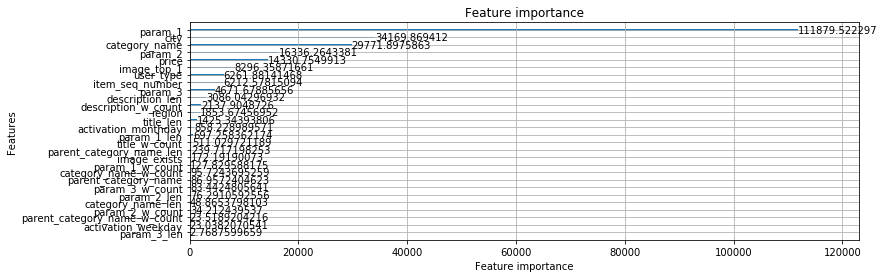

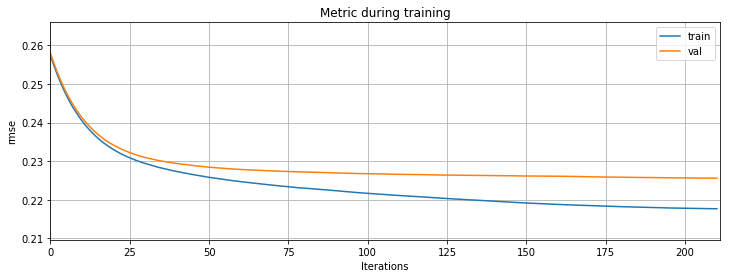

In [48]:
params['learning_rate']=0.05
lgbr=lgb.LGBMRegressor(**params)
get_lgb_params(params,cvparams,tran_table)
feat_imp=modelfit(lgbr,X_train,y_train,X_val,y_val,cat_vars,cvparams,useTrainCV=True,cv_folds=5,early_stopping_rounds=30)

[20]	cv_agg's rmse: 0.22934 + 0.000249898
[40]	cv_agg's rmse: 0.227272 + 0.000249635
[60]	cv_agg's rmse: 0.226636 + 0.000282374
[80]	cv_agg's rmse: 0.226329 + 0.000300891
[100]	cv_agg's rmse: 0.226005 + 0.000325974
[120]	cv_agg's rmse: 0.225993 + 0.000318259
Best Iteration: 105
[20]	train's rmse: 0.227309	val's rmse: 0.229323
[40]	train's rmse: 0.223227	val's rmse: 0.22709
[60]	train's rmse: 0.220778	val's rmse: 0.226496
[80]	train's rmse: 0.218942	val's rmse: 0.226134
[100]	train's rmse: 0.217789	val's rmse: 0.225798
Model report on trian:
Train RMSE:0.2176
Model report on test:
Test RMSE:0.2257


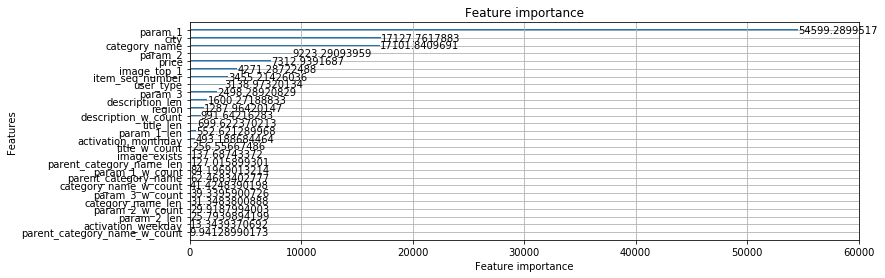

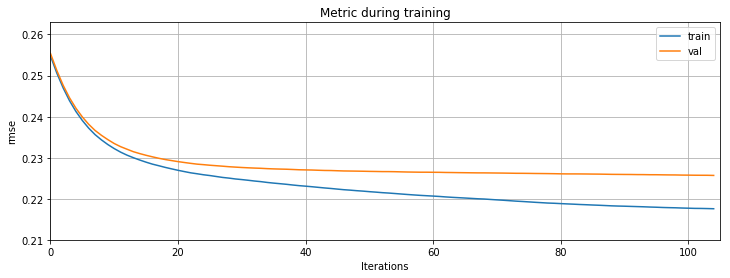

In [49]:
params['learning_rate']=0.1
lgbr=lgb.LGBMRegressor(**params)
get_lgb_params(params,cvparams,tran_table)
feat_imp=modelfit(lgbr,X_train,y_train,X_val,y_val,cat_vars,cvparams,useTrainCV=True,cv_folds=5,early_stopping_rounds=30)

In [50]:
params['learning_rate']=0.05
params['n_estimators']=211

# 3 Final model

In [51]:
params

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.9,
 'learning_rate': 0.05,
 'max_bin': 168,
 'max_depth': 30,
 'min_child_samples': 20,
 'min_child_weight': 1e-05,
 'min_split_gain': 0.17,
 'n_estimators': 211,
 'n_jobs': -1,
 'num_leaves': 149,
 'objective': 'regression',
 'random_state': 9,
 'reg_alpha': 0,
 'reg_lambda': 0.9,
 'subsample': 1.0,
 'subsample_freq': 1}

In [52]:
lgbr_opt=lgb.LGBMRegressor(**params)

In [53]:
lgbr_opt.fit(train_X,train_y,feature_name=list(train_X.columns),categorical_feature=cat_vars)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
       learning_rate=0.05, max_bin=168, max_depth=30, min_child_samples=20,
       min_child_weight=1e-05, min_split_gain=0.17, n_estimators=211,
       n_jobs=-1, num_leaves=149, objective='regression', random_state=9,
       reg_alpha=0, reg_lambda=0.9, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1)

In [54]:
pred_test=lgbr_opt.predict(test_X)

In [55]:
pred_test[pred_test > 1] = 1
pred_test[pred_test < 0] = 0
sub_df = pd.DataFrame({"item_id": test_id})
sub_df["deal_probability"] = pred_test
sub_df.to_csv(data_dirs['pred_result'], index=False)

In [57]:
sub_df.head()

,item_id,deal_probability
0,6544e41a8817,0.085082
1,65b9484d670f,0.138392
2,8bab230b2ecd,0.192306
3,8e348601fefc,0.055458
4,8bd2fe400b89,0.241162


In [61]:
public_score=0.2299

In [62]:
feat_imp

activation_hour                    0
param_3_len                        0
parent_category_name_w_count       1
param_2_len                        2
param_2_w_count                    3
param_3_w_count                    4
category_name_len                  4
param_1_w_count                    4
category_name_w_count              5
image_exists                       7
parent_category_name              12
activation_weekday                12
parent_category_name_len          14
param_1_len                       22
title_w_count                     97
user_type                        208
description_w_count              269
title_len                        364
description_len                  382
item_seq_number                  506
activation_monthday              530
param_3                          623
region                           683
category_name                    847
image_top_1                      994
param_2                         1077
price                           1312
p